In [1]:
import pandas as pd
import numpy as np
from os.path import join
import xarray as xr
import matplotlib.pyplot as plt
import joblib, os, sys, math
import pandas as pd
import numpy as np
from datetime import *
import sqlite3
from mpl_toolkits.basemap import *
from cartopy.geodesic import Geodesic

In [2]:
%%time
labels = pd.read_parquet('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_labels_2016_2019_w_LR.parquet') # raw probability file for each storm object (not on 80-km grid)
labels = labels[labels['Run_Date'] <= np.datetime64('2016-12-31')]

CPU times: user 212 ms, sys: 88.7 ms, total: 300 ms
Wall time: 614 ms


In [3]:
df = pd.read_pickle('report_distances_to_storm.pk')

prob_bins = np.arange(0,1.01,0.1)
df = df[df['thresh'] == 2]

cond_probs = {}
for hazard in ['torn', 'wind', 'hailone', 'sighail', 'sigwind', 'any']:
    if hazard == 'any':
        all_dist = np.array( [ df[df['hazard']=='torn']['dist'].values, df[df['hazard']=='hailone']['dist'].values, df[df['hazard']=='wind']['dist'].values ]).T
        all_dist = np.where(all_dist < 0, 999999, all_dist)
        min_dist = np.nanmin(all_dist, axis=1)
        
        storm_subset = df[(df['hazard'] == hazard)]
        storm_subset['dist'] = min_dist # redefine dist for this hazard as dist for any report
    else: 
        storm_subset = df[(df['hazard'] == hazard)]

    for mode in ['Supercell', 'QLCS', 'Disorganized']:
        all_probs = []
        for p,prob in enumerate(prob_bins[:-1]):
            prob_filter = (labels[f'LR_{mode}_prob'] >= prob_bins[p]) & (labels[f'LR_{mode}_prob'] < prob_bins[p+1])
            bin_storms = storm_subset[prob_filter.values]
    
            num_yes = ( (bin_storms['dist'] > 0) & (bin_storms['dist'] <= 80 )).sum()
            freq = num_yes/float(len(bin_storms))
            
            all_probs.append( freq )
        cond_probs[mode+"_"+hazard] = all_probs


/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


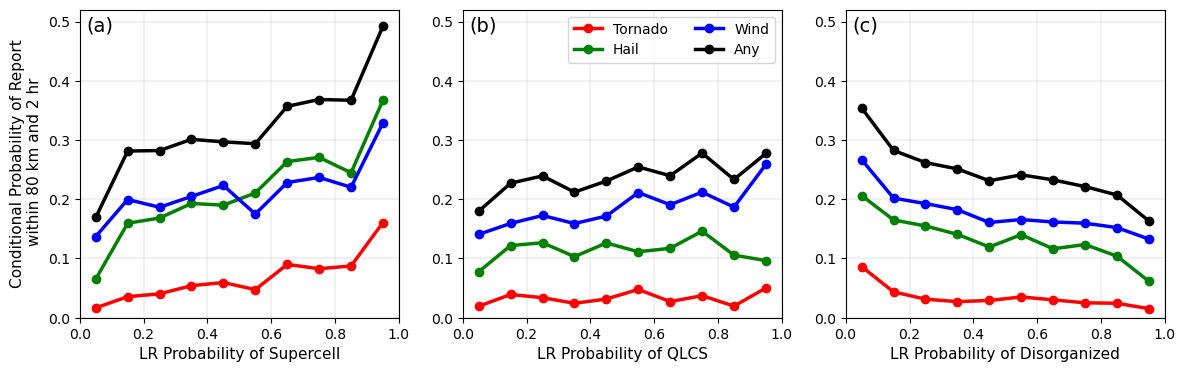

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(14,4))
axes = axes.flatten()
panels = ['(a)', '(b)', '(c)']

for i, mode in enumerate(['Supercell', 'QLCS', 'Disorganized']):
    axes[i].plot(prob_bins[:-1]+0.05, cond_probs[mode+"_torn"], color='red', label='Tornado', lw=2.5, marker='o')
    axes[i].plot(prob_bins[:-1]+0.05, cond_probs[mode+"_hailone"], color='green', label='Hail', lw=2.5, marker='o')
    #axes[i].plot(prob_bins[:-1]+0.05, cond_probs[mode+"_sighail"], color='gray', label='Sig. Hail', lw=2.5, marker='o')
    #axes[i].plot(prob_bins[:-1]+0.05, cond_probs[mode+"_sigwind"], color='gray', label='Sig. Wind', lw=2.5, marker='o')
    axes[i].plot(prob_bins[:-1]+0.05, cond_probs[mode+"_wind"], color='blue', label='Wind', lw=2.5, marker='o' )
    axes[i].plot(prob_bins[:-1]+0.05, cond_probs[mode+"_any"], color='black', label='Any', lw=2.5, marker='o' )
    
    axes[i].grid(lw=0.25)
    axes[i].set_xlabel(f'LR Probability of {mode}', fontsize=11)
    axes[i].set_ylim((0,0.52))
    axes[i].set_xlim((0,1))
    if i == 0: axes[i].set_ylabel('Conditional Probability of Report\n within 80 km and 2 hr', fontsize=11)
    if i == 1: axes[i].legend(ncol=2)
    axes[i].text(0.02, 0.98, panels[i], fontsize=14, fontweight='normal', transform=axes[i].transAxes, va='top', ha='left')
    
#plt.savefig('cond_prob_objects.pdf', bbox_inches='tight')